## Custom conversational bot using character-level language model


> I have chosen the simplest model to implement, the first option described which is the Generative n-gram language model. This is largely due to the unavailability of computational resources, I have just a laptop with no GPU access and just a 4GB RAM. It would be extremely difficult to construct, train and test more complex models. I am also facing a time crunch, thus this model is rather inefficient and leaves a lot to be desired, and can be improved if given time. 

>Inspiration and code snippets have been taken from Prof. Yoav Goldberg's excellent blog post: http://nbviewer.jupyter.org/gist/yoavg/d76121dfde2618422139. Please do give it a read, if you have not done so already. 

I expanded on n-gram character model described by Prof. Goldberg. The task is different, here we wish to train a conversational bot. 

I chose to use the Cornell Dialogues dataset(filtered and preprocessed using the code provided). 

For each question and answer pair, I train the model using the text snippet of the (question,answer) tuple by concatenating the question and answer, with a full stop in between. I hope this teaches the model to end sentences on its own. 

The problem of unseen data arises when we go for the vanilla n-gram model. In this model, a probabilistic model of seen "histories" and the character that follows them is calculated from the training data. However, if new data is seen which has an unseen "history", then we run into a problem. 

I have tackled this problem by training multiple n-gram models (n=20,15,12,8,6,4,3,2,1). During generation, the history is searched for in the n-gram model with the largest n. If it is found, then next character generation is done according to the probabilities present in that n-gram model. Otherwise, it is searched for in the next smallest n-gram model. Almost all normal sequences will be found in the 2-gram and 1-gram models. Even otherwise, if it is not found in any, then a full stop is output. 

For large n, the size of the dictionary becomes too large. Thus I discard rarely seen histories to reduce the size of the model. I have made a design choice to terminate the chatbot reply with the first fullstop that is outputted. 

## Code

In [1]:
import numpy as np
import tqdm
import pickle
import sys
from random import random

In [2]:
import datasets

## Training character-level language model

In [3]:
from collections import *

def train_char_lm(data, order):
    lm = defaultdict(Counter)
    pad = "~" * order
    min_count=1
    if order>9:
        min_count=2
    if order>15:
        min_count=3
    
    for i in tqdm.tqdm(range(len(data))):
        sent = pad + data[i][0] + ". " + data[i][1] + "."
        for j in range(len(sent)-order):
            history, char = sent[j:j+order], sent[j+order]
            if history in lm:
                s = float(sum(lm[history].values()))
            else:
                s = 0
            if order<=12 or (s<min_count and random()<0.1) or s>=min_count:
                lm[history][char]+=1
            
    def normalize(counter,min_count=3):
        s = float(sum(counter.values()))
        return [(c,counter[c]/s) for c in counter.keys()]

    print(len(lm))
    outlm = {}
    for hist in tqdm.tqdm(lm.keys()):
        outlm[hist] = normalize(lm[hist],min_count)
    
    return outlm

## Reading Cornell Dataset (processed using code provided), storing for easy future use

In [4]:
max_len = 100
data = datasets.readCornellData("../data/cornell", max_len=max_len)

100%|██████████| 83097/83097 [00:14<00:00, 5929.39it/s]


In [7]:
with open('cornell_data_%d'%max_len, 'wb') as file:
    pickle.dump(data, file)

In [4]:
with open('cornell_data_100', 'rb') as file:
    data = pickle.load(file)

In [5]:
print(len(data))

170545


In [6]:
print(data[:20])

[('well i thought wed start with pronunciation if thats okay with you', 'not the hacking and gagging and spitting part please'), ('not the hacking and gagging and spitting part please', 'okay then how bout we try out some french cuisine saturday night'), ('youre asking me out thats so cute whats your name again', 'forget it'), ('no no its my fault we didnt have a proper introduction', 'cameron'), ('gosh if only we could find kat a boyfriend', 'let me see what i can do'), ('cesc ma tete this is my head', 'right see youre ready for the quiz'), ('thats because its such a nice one', 'forget french'), ('how is our little find the wench a date plan progressing', 'well theres someone i think might be'), ('there', 'where'), ('you have my word as a gentleman', 'youre sweet'), ('sure have', 'i really really really wanna go but i cant not unless my sister goes'), ('i really really really wanna go but i cant not unless my sister goes', 'im workin on it but she doesnt seem to be goin for him'), ('s

## Training n-gram character models
Store them for easy retrieval later

In [7]:
order_list = [20,15,12,8,6,4,2,1]

In [ ]:
for order in order_list:
    lm = train_char_lm(data, order=order)
    a = np.array(sys.getsizeof(lm))
    print(len(lm),np.sum(a)/1000000)
    with open('dicts/cornell_%d'%order, 'wb') as file:
        pickle.dump((lm,order), file)
        del lm

## ChitchatBot class

In [8]:
from random import random

class ChitchatBot(object):
    def __init__(self,foldername,order_list):
        self.order_list = order_list
        self.lm_list = []
        print("Loading chitchat bot...")
        for order in self.order_list:
            with open(foldername+'/cornell_%d'%order,'rb') as file:
                lm,_ = pickle.load(file)
                self.lm_list.append(lm)
                print("loaded %d-gram model"%order)


    def generate_letter(self,history):
        for i in range(len(self.lm_list)):
            lm = self.lm_list[i]
            order = self.order_list[i]
            hist = history[-order:]
            if hist in lm:
                dist = lm[hist]
                x = random()
                for c,v in dist:
                    x = x - v
                    if x <= 0: 
#                         print(hist,c,"   :  %d-gram response"%order)
                        return c
            else:
                continue
        return '.'

    def get_response(self,question):
        max_order = self.order_list[0]
        history = "~" * max_order + question + ". "
        history = history[-max_order:]
        out = []
        while True:
            c = self.generate_letter(history)
            history = history[-max_order:] + c
            out.append(c)
            if c=='.':
                break
        return "".join(out)
    
    def generate_text(self, nletters=50):
        max_order = self.order_list[0]
        history = "~" * max_order
        out = []
        for i in range(nletters):
            c = self.generate_letter(history)
            history = history[-max_order:] + c
            out.append(c)
        return "".join(out)

In [18]:
bot = ChitchatBot("dicts",[15,8,6,3,2,1])

Loading chitchat bot...
loaded 15-gram model
loaded 8-gram model
loaded 6-gram model
loaded 3-gram model
loaded 2-gram model
loaded 1-gram model


## Example text and reply generated by bot

In [35]:
print(bot.generate_text(1000))

i hadnt never heard of a cure. i do. it was to make it. no please. i meant in general. pilots always. hold me. and youre a while. then you should not betray the game oneonone kinda like that aint what was our money for crissakes you think hell learn. look it upon myself got it. one went down everybody. down here. this part removes his weapon. turn the table. i havent seen him in here. where are the place. are the plunging her. i love you. no. stay at my table. they say is true i mean. i can see you couldnt. not really know this one is full of fuel. those radio. we have lost but we have to me isnt it. i want i still dont. they took my wheels. no. yes you are better than a common man dont know how it keeps me so many appointment. oh thats just met but were stuck out of town. you talking gallons. ive always make a little leonitchka. arent they get caught. something like that there is no solution. you sure there a younger. you and you and hes theres a killer too. no. good idea to tell anyb

In [44]:
print(bot.get_response("i play football"))

i dont understand.


## Results

The chatbot can be found on Telegram at @mission_impossible_bot (http://t.me/mission_impossible_bot) 

The above chatbot model is used as the chitchat bot from the final course assignment. However, due to limited memory on the AWS free server, it has been disabled. It however detects whether you asked for help from stackoverflow. The bot which does this job can be found at @allknowing_bot. 

There are two other features also:
To use as a calculator, type "Calc:" followed by the expression you wish to evaluate. eg. "Calc: 4+3"
To check the time, type "Time?"

When the intent classifier classifies it as dialogue, the model we trained above comes into action as described previously. 

The results are quite poor. I dont know whether it is a problem with the dataset, but the bot tends to display violent and dominating rude behavior, almost as if it was trained on the subtitles of only crime thrillers! It is good fun though, and it was a great experience implementing this naive algorithm for a chatbot. 

## The good, bad and the ugly

In [49]:
from IPython.display import Image
from IPython.core.display import HTML 

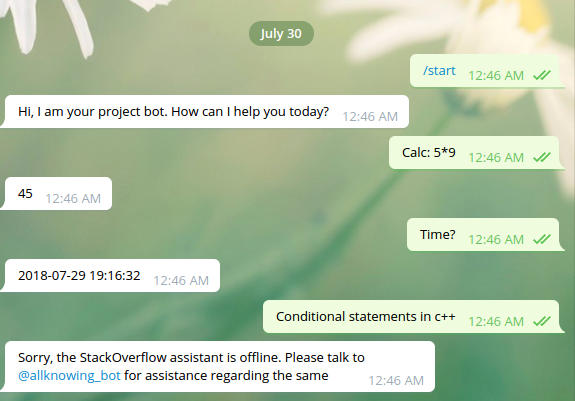

In [52]:
Image(filename = "1.png")

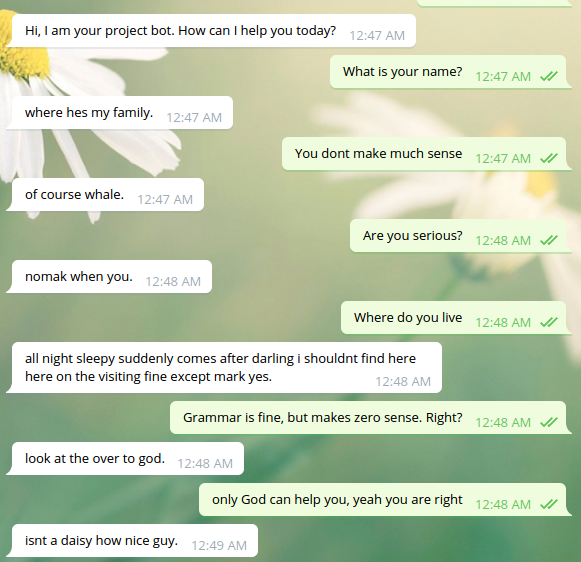

In [53]:
Image(filename = "2.png")

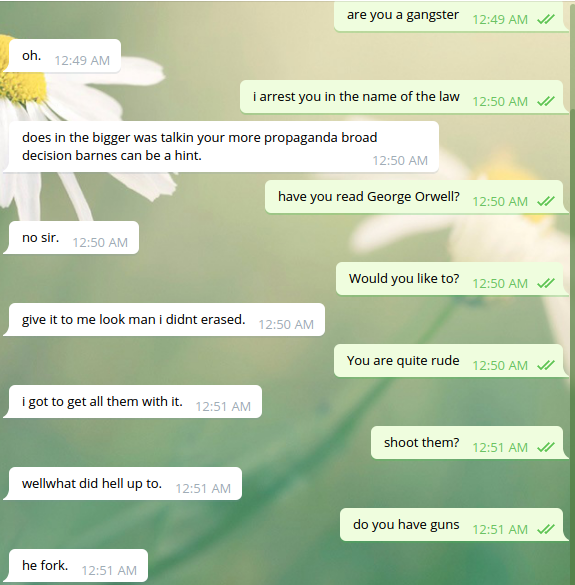

In [54]:
Image(filename = "3.png")

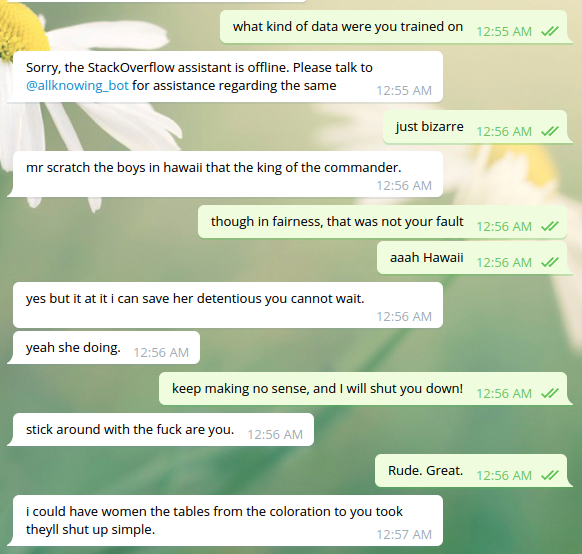

In [55]:
Image(filename = "4.png")

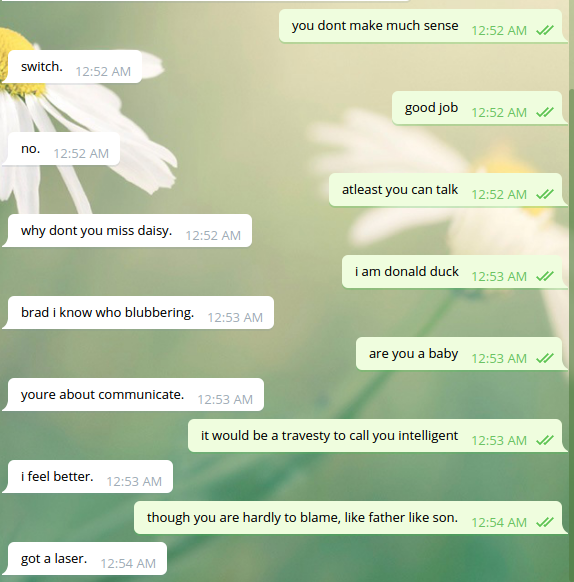

In [56]:
Image(filename = "5.png")

## Limitations of model:
1. It is extremely naive. 
2. It could do with some smoothing mechanism, the ensemble of n-gram models is redundant and inefficient. 
3. It can deal with only small input questions, equal to the order of 
4. There is no 'comprehension' per se of the question, like there would have to be in a seq2seq model. 
5. Sometimes the answers given are extremely short. A lot of the time, the answers are irrelevant and bizarre.

Despite all this, I believe it is a good first attempt. It satisfies the requirements: it is up and running, has decent grammar, somewhat meaningful sentences and gives different (and ridiculous) responses to different questions. 
It doesn't do too well on small talk, but oh well. 

## Thanks for reading!